## Visualization of different validation techniques

Comparison between "Fast.AI's Rectangular Image Crop", "Imagenet Center Crop", "Test Time Augmentation"

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import urllib.request

import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from validation_utils import sort_ar, map_idx2ar, ValDataset, RectangularCropTfm

In [2]:
data = Path.home()/'data/imagenet'
valdir = data/'validation'
batch_size = 128

### Map Images to Aspect ratio

In [3]:
idx_ar_sorted = sort_ar(data, valdir)

OR just download the precomputed indexes

In [4]:
idx2ar_path = data/'sorted_idxar.p'
url = 'https://s3-us-west-2.amazonaws.com/ashaw-fastai-imagenet/sorted_idxar.p'
if not idx2ar_path.exists(): urllib.request.urlretrieve(url, idx2ar_path)
idx_ar_sorted = sort_ar(data, valdir)

#### Let's make sure it's sorted

In [5]:
print('First five:', idx_ar_sorted[:5])
print('Last five:', idx_ar_sorted[-5:])

First five: [(24381, 0.20427), (31757, 0.26728), (39886, 0.27256), (21302, 0.28111), (21333, 0.3175)]
Last five: [(21629, 3.86301), (38868, 4.53237), (25514, 4.70707), (38211, 5.30363), (34168, 5.8626)]


### Prepare Datasets

In [7]:
val_bs = 128
idx2ar, _ = map_idx2ar(idx_ar_sorted, val_bs)
target_size = 128

# Original Images
orig_dataset = datasets.ImageFolder(valdir, transforms.Resize(target_size))

# Center Crop
val_tfms = [transforms.Resize(int(target_size*1.14)), transforms.CenterCrop(target_size)]
val_dataset = datasets.ImageFolder(valdir,  transforms.Compose(val_tfms))

# Rect
val_rect_tfms = [transforms.Resize(int(target_size*1.14)), RectangularCropTfm(idx2ar, target_size)]
val_dataset_rect = ValDataset(valdir, val_rect_tfms)

# TTA Augmentations
min_scale = 0.5
trn_tfms = [transforms.RandomResizedCrop(target_size, scale=(min_scale, 1.0)),
            transforms.RandomHorizontalFlip()]
tta_aug_dataset = datasets.ImageFolder(valdir, transforms.Compose(trn_tfms))


In [8]:
def show_validation_image(sorted_index, figsize=(10,10)):
    index, aspect_ratio = idx_ar_sorted[sorted_index]
    print('Aspect ratio:', aspect_ratio)
    f, (ax1, ax2, ax3) = plt.subplots(3, 2, figsize=figsize)
    f.tight_layout(h_pad=6.0)
    fontsize = 15
    ax1[0].imshow(orig_dataset[index][0])
    ax1[0].set_title('Center Crop Image', fontsize=fontsize)
    ax1[1].imshow(val_dataset_rect[index][0])
    ax1[1].set_title('FastAi Rectangular Crop', fontsize=fontsize)
    ax2[0].imshow(val_dataset[index][0])
    ax2[0].set_title('Imagenet Center Crop', fontsize=fontsize)
    ax2[1].imshow(tta_aug_dataset[index][0])
    ax2[1].set_title('Test Time Augmentation 1', fontsize=fontsize)
    ax3[0].imshow(tta_aug_dataset[index][0])
    ax3[0].set_title('Test Time Augmentation 2', fontsize=fontsize)
    ax3[1].imshow(tta_aug_dataset[index][0])
    ax3[1].set_title('Test Time Augmentation 3', fontsize=fontsize)

### Let's see what tall images look like (Aspect ratio < 1)

Lots of these images are objects or figures. Helps to see the whole thing

Aspect ratio: 0.43085


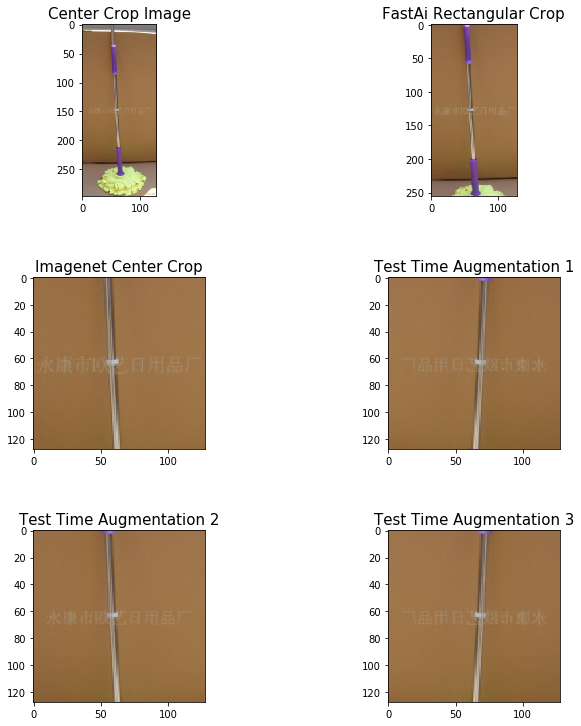

In [9]:
show_validation_image(22)

Aspect ratio: 0.46


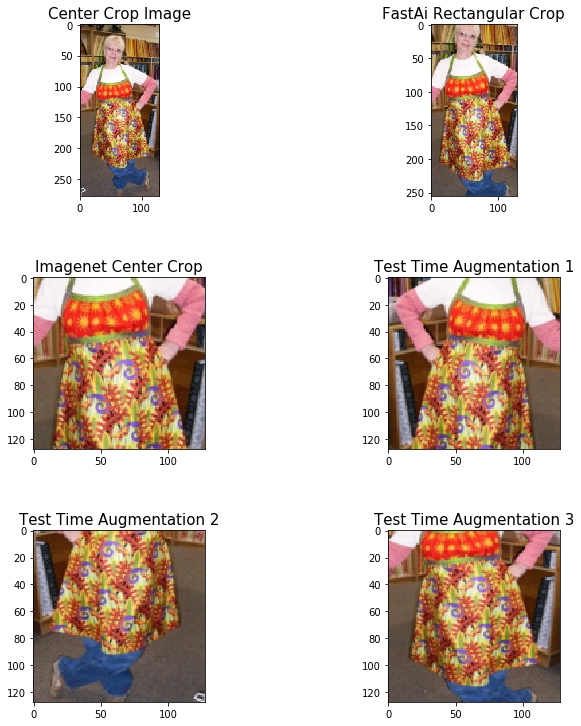

In [10]:
show_validation_image(32)

### Wide images (Aspect ratio > 1)

Aspect ratio: 3.86301


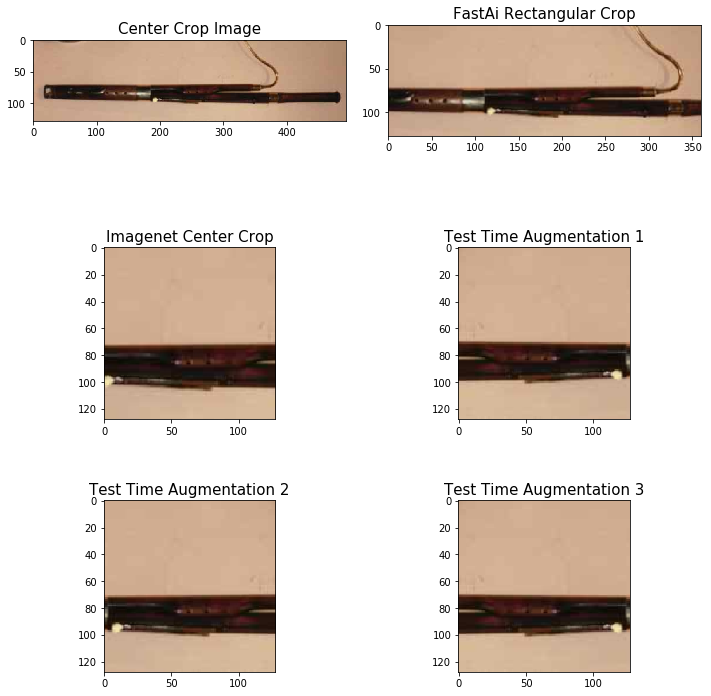

In [11]:
show_validation_image(-5)

Aspect ratio: 2.91925


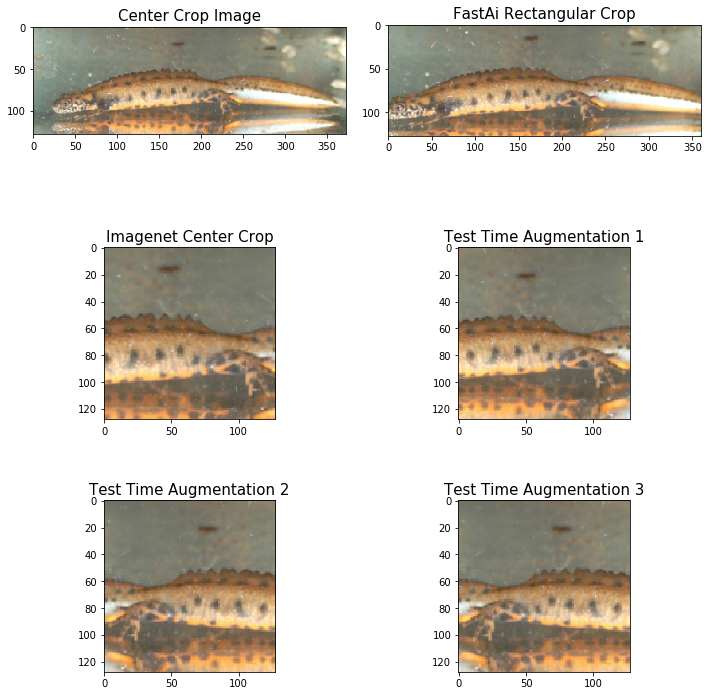

In [12]:
show_validation_image(-23)

### Already square images - Aspect ratio ~1

Not much data loss here:

Aspect ratio: 1.08932


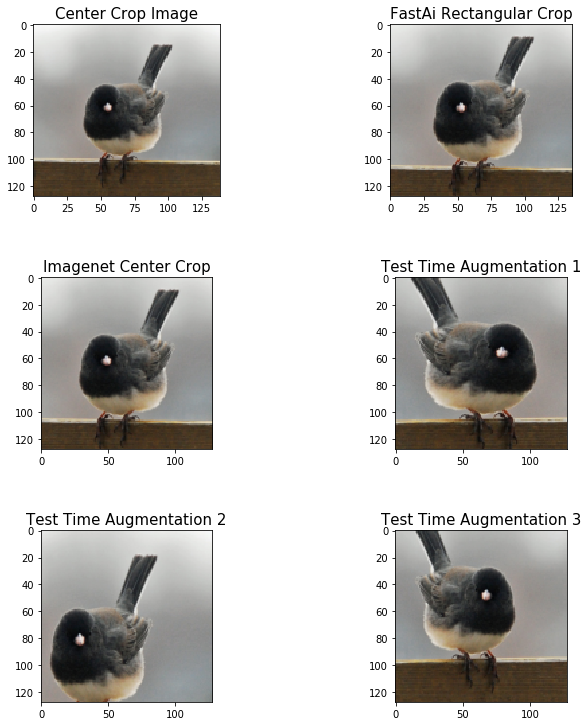

In [13]:
show_validation_image(len(idx_ar_sorted)//3)